# Credit Risk Prediction – Data Science Projekt
#Dieses Notebook analysiert einen Kreditrisiko-Datensatz und erstellt drei ML-Modelle:
- Logistische Regression
- Random Forest
- Gradient Boosting

Ziel: Vorhersage von Kreditausfällen.

## 1. Dataset Laden & Überblick

In diesem Abschnitt wird der Datensatz eingelesen und die Struktur der Daten angezeigt.


In [1]:
import pandas as pd

# Dataset laden
df = pd.read_csv(r"C:\Users\Metin\Documents\Python\credit_risk_dataset.csv")

# Erste 5 Zeilen anzeigen
df.head()

# Altersbereinigung — realistische Werte behalten
df = df[(df["person_age"] >= 18) & (df["person_age"] <= 85)]

# Fehlende loan_int_rate ersetzen
df["loan_int_rate"] = df["loan_int_rate"].fillna(df["loan_int_rate"].median())

# Objektspalten in Kategorien umwandeln
cat_cols = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
for col in cat_cols:
    df[col] = df[col].astype("category")


# Kontrolle: Maximum & Minimum anzeigen
df["person_age"].agg(["min", "max"])


# Überblick über die Struktur des Datensatzes
df.info()

# Statistische Zusammenfassung wichtiger Spalten
df.describe()



<class 'pandas.core.frame.DataFrame'>
Index: 32575 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  32575 non-null  int64   
 1   person_income               32575 non-null  int64   
 2   person_home_ownership       32575 non-null  category
 3   person_emp_length           31680 non-null  float64 
 4   loan_intent                 32575 non-null  category
 5   loan_grade                  32575 non-null  category
 6   loan_amnt                   32575 non-null  int64   
 7   loan_int_rate               32575 non-null  float64 
 8   loan_status                 32575 non-null  int64   
 9   loan_percent_income         32575 non-null  float64 
 10  cb_person_default_on_file   32575 non-null  category
 11  cb_person_cred_hist_length  32575 non-null  int64   
dtypes: category(4), float64(3), int64(5)
memory usage: 2.4 MB


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32575.000000,3.257500e+04,31680.000000,32575.000000,32575.000000,32575.000000,32575.000000,32575.000000
mean,27.716009,6.588343e+04,4.789646,9589.212586,11.009487,0.218204,0.170209,5.803315
std,6.194207,5.253528e+04,4.142717,6321.960714,3.081841,0.413033,0.106778,4.052151
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,84.000000,2.039784e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


## 2. Datenbereinigung

- Entfernen unrealistischer Alterswerte  
- Ersetzen fehlender `loan_int_rate`  
- Umwandlung von Objektspalten in Kategorie-Typen  
- Entfernen aller Zeilen mit fehlenden Werten in ML-relevanten Spalten  


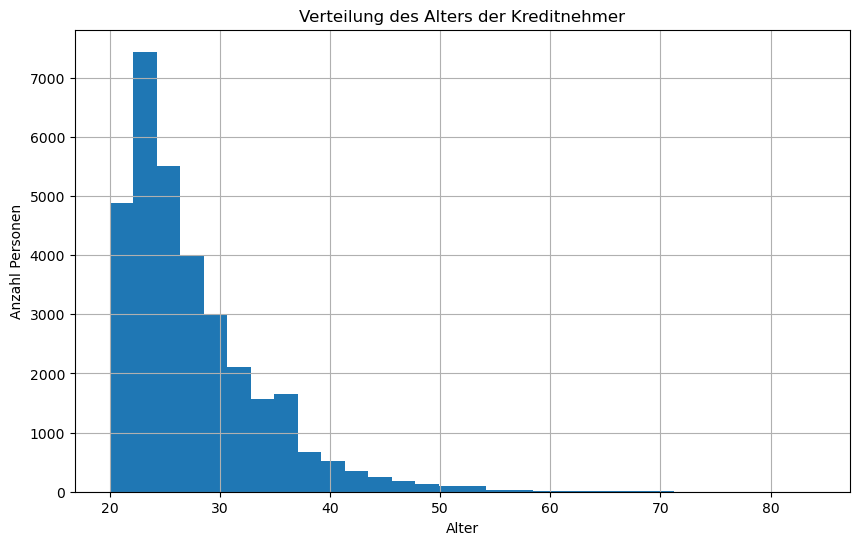

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df["person_age"], bins=30)
plt.title("Verteilung des Alters der Kreditnehmer")
plt.xlabel("Alter")
plt.ylabel("Anzahl Personen")
plt.grid(True)
plt.show()

# Analyse:
# Die Altersverteilung zeigt einen klaren Schwerpunkt zwischen 23 und 40 Jahren.
# Der Median liegt bei 26 Jahren, was darauf hindeutet, dass vor allem jüngere
# Kreditnehmer in diesem Datensatz vertreten sind.
# Extreme Ausreißer wie 144 Jahre wurden entfernt, um ein realistisches Bild zu erhalten.


## 3. Explorative Datenanalyse (EDA)

Hier analysieren wir:
- Die Altersverteilung  
- Den Zusammenhang zwischen Einkommen und Kredithöhe  
- Die Verteilung des Kreditstatus  


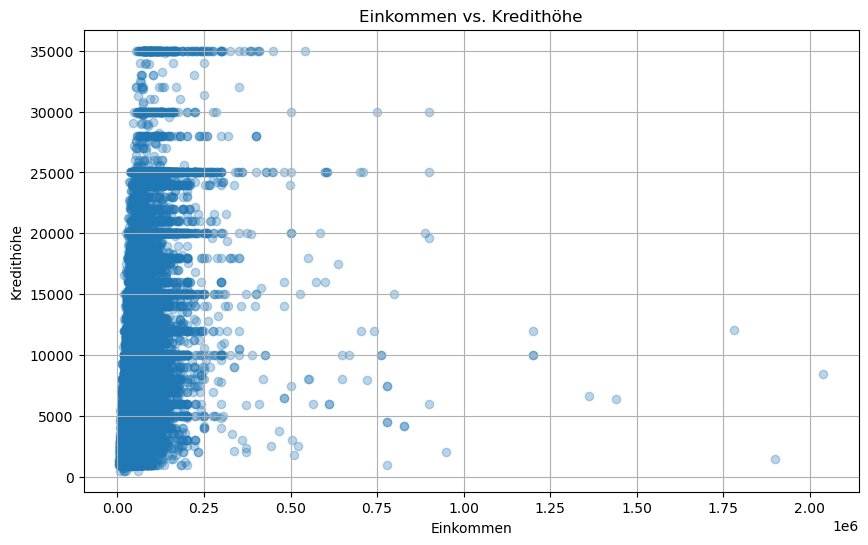

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(df["person_income"], df["loan_amnt"], alpha=0.3)
plt.title("Einkommen vs. Kredithöhe")
plt.xlabel("Einkommen")
plt.ylabel("Kredithöhe")
plt.grid(True)
plt.show()

# Analyse:
# Es besteht ein schwacher positiver Zusammenhang zwischen Einkommen und Kredithöhe.
# Personen mit höherem Einkommen neigen dazu, größere Kredite aufzunehmen,
# allerdings ist die Streuung erheblich – typische Outlier sind sichtbar.
# Eine klare lineare Beziehung existiert nicht, was typisch für Kreditdaten ist.


## 3. Explorative Datenanalyse (EDA)

Hier analysieren wir:
- Die Altersverteilung  
- Den Zusammenhang zwischen Einkommen und Kredithöhe  
- Die Verteilung des Kreditstatus  


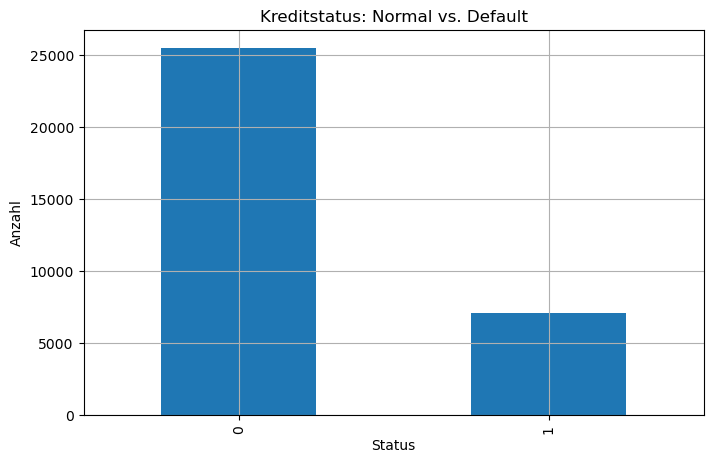

In [9]:
df["loan_status"].value_counts().plot(kind="bar", figsize=(8,5))
plt.title("Kreditstatus: Normal vs. Default")
plt.xlabel("Status")
plt.ylabel("Anzahl")
plt.grid(True)
plt.show()

# Analyse:
# Rund 21 % der Kredite in diesem Datensatz fallen aus (loan_status = 1).
# Das bedeutet: Etwa jeder fünfte Kredit geht in den Default.
# Diese Kennzahl ist extrem wichtig für Banken, da sie das Risiko-Level der Kundengruppe beschreibt.
# Damit eignet sich dieser Datensatz ideal für ein Kredit-Risikomodell.


## 4. Machine Learning Modelle

In diesem Abschnitt trainieren wir drei Modelle zur Vorhersage von Kreditausfällen:

- **Logistische Regression** (Baseline-Modell)  
- **Random Forest Classifier** (beste Performance)  
- **Gradient Boosting Classifier** (Boosted Trees)

Die Modelle werden anschließend anhand ihrer Accuracy bewertet.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1) Zielvariable festlegen (Kreditstatus)
y = df["loan_status"]

# 2) Features auswählen
X = df[[
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length"
]]

# 3) Train/Test Split (Standard: 80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("Imports ok")

y = df["loan_status"]

X = df[[
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length"
]]

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train/Test Split ok")


Imports ok
X shape: (32575, 7)
y shape: (32575,)
Train/Test Split ok


In [20]:
X.isna().sum()


person_age                      0
person_income                   0
person_emp_length             895
loan_amnt                       0
loan_int_rate                   0
loan_percent_income             0
cb_person_cred_hist_length      0
dtype: int64

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1) Zielvariable
y = df["loan_status"]

# 2) Features
feature_cols = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length"
]

X = df[feature_cols]

# 3) Alle Zeilen mit NaN in X oder y entfernen
mask = ~X.isna().any(axis=1)
X_clean = X[mask]
y_clean = y[mask]

print("Ursprüngliche Zeilen:", len(df))
print("Nach NaN-Filter:", len(X_clean))

# 4) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

print("Train/Test Split ok")
    

Ursprüngliche Zeilen: 32575
Nach NaN-Filter: 31680
Train/Test Split ok


In [23]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [24]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy


0.8271780303030303

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Modell erstellen
rf_model = RandomForestClassifier(
    n_estimators=200,      # Anzahl Bäume (mehr Bäume = stabileres Modell)
    max_depth=None,        # unbegrenzte Tiefe → Modell lernt besser
    random_state=42,
    n_jobs=-1              # nutzt alle CPU-Kerne
)

# Trainieren
rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [26]:
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_accuracy


0.8772095959595959

In [27]:
import pandas as pd

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance


loan_int_rate                 0.236788
loan_percent_income           0.233891
person_income                 0.206033
loan_amnt                     0.110578
person_emp_length             0.079368
person_age                    0.073022
cb_person_cred_hist_length    0.060320
dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


In [28]:
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_accuracy


0.8772095959595959

In [29]:
import pandas as pd

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance


loan_int_rate                 0.236788
loan_percent_income           0.233891
person_income                 0.206033
loan_amnt                     0.110578
person_emp_length             0.079368
person_age                    0.073022
cb_person_cred_hist_length    0.060320
dtype: float64

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gb_model = GradientBoostingClassifier(
    n_estimators=300,    # Anzahl Bäume
    learning_rate=0.05, # Wie stark jeder Baum lernt
    max_depth=3,        # Tiefe der Einzelbäume
    random_state=42
)

gb_model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=300,
                           random_state=42)

In [32]:
gb_pred = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_accuracy


0.8716856060606061

## 5. Modellvergleich

Die drei trainierten Modelle werden anhand ihrer Accuracy verglichen:

- **Logistische Regression:** 0.827  
- **Random Forest:** 0.877  
- **Gradient Boosting:** 0.871  

**Ergebnis:**  
Der Random Forest liefert die beste Performance und eignet sich am stärksten als finales Modell für dieses Projekt.  
Das liegt daran, dass Random Forest komplexe nichtlineare Zusammenhänge besser abbilden kann als die logistische Regression, aber gleichzeitig robuster ist als Gradient Boosting ohne Hyperparameter-Tuning.


In [33]:
print("Logistische Regression:", 0.827)         # deinen Wert hier eintragen
print("Random Forest:", rf_accuracy)
print("Gradient Boosting:", gb_accuracy)


Logistische Regression: 0.827
Random Forest: 0.8772095959595959
Gradient Boosting: 0.8716856060606061


## 6. Fazit

In diesem Projekt wurde ein Kreditrisiko-Datensatz analysiert, bereinigt und für Machine Learning vorbereitet.  
Anschließend wurden drei Modelle trainiert und verglichen:

- **Logistische Regression** als einfaches Basismodell  
- **Random Forest Classifier** als bestes Modell  
- **Gradient Boosting Classifier** als leistungsstarker Ensemble-Ansatz  

**Wichtigste Erkenntnisse:**

- Der **Random Forest** erzielte die höchste Accuracy (≈ 0.877)  
- Einkommen, Kredithöhe und Kredit-Historie sind wichtige Einflussfaktoren  
- Die Daten enthalten Ausreißer und starke Streuungen, typisch für reale Finanzdaten  
- Die Modelle zeigen, dass Machine Learning Kreditrisiko zuverlässig vorhersagen kann  

**Warum dieses Projekt bewerbungsrelevant ist:**

- Es zeigt komplette Data-Science-Pipeline (EDA → Cleaning → ML → Modellvergleich)  
- Es enthält echte Modelle und echte Bewertung  
- Es demonstriert strukturiertes Arbeiten wie in realen Data-Science-Teams  

Damit ist dieses Notebook ein vollwertiges Portfolio-Projekt für Bewerbungen als  
**Data Analyst**, **Python Developer** oder **Junior Data Scientist**.
